In [18]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

##### NOTE: In the previous homeworks, we had to deal with a number of complications which made the grading process unnecessarily harder.  While some were a result of us not making explicit requests about programming practices, others were a result of students not following explicit instructions.  Most of these are very easy for each of you to address individually, while they end up piling up on our end.  Before submitting, make sure you are adhering to the following rules, which helps us grade your assignment.  Each rule is associated with a penalty.

 * (-1pts) Make sure your notebook only contains the exercises requested in the notebook, and the written homework (if any) is delivered in class in printed form, i.e. don't submit your written homework as part of the notebook.
 * (-1pts) Make sure you are using Python3.  This notebook is already set up to use Python3 (top right corner);  Do not change this.
 * (-1pts) If a method is provided with a specific signature, do not change the signature in any way, or the default values.
 * (-1pts) Don't hard-code your solutions to the specific environments which it is being used on, or the specific hyper-parameters which it is being used on;  Be as general as possible, which means also using ALL the arguments of the methods your are implementing.
 * (-1pts) Make sure your submission file follows the format indicated in blackboard and, most importantly, contains your name.
 * (-1pts) Clean up your code before submitting, i.e. remove all print statements that you've used to develop and debug (especially if it's going to clog up the interface by printing thousands of lines).  Only output whatever is required by the exercise.
 * (-2pts) For technical reasons, plots should be contained in their own cell which should run instantly, separate from cells which perform longer computations.  This notebook is already formatted in such a way, please make sure this remains the case.
 * (-5pts or more) Make sure your notebook runs completely, from start to end, without raising any unintended errors.  After you've made the last edit, Use the option `Kernel -> Restart & Run All` to rerun the entire notebook.  If you end up making ANY edit, re-run everything again.  Always assume any edit you make may have broken your code!  About 10% of the previous homeworks would not run from start to end until something was fixed, which represented a huge effort for the grading process.

# Homework 6: Deep Q-Networks in Pytorch

In this assignment you will implement deep q-learning using Pytorch.

In [19]:
import copy
import math
import os
from collections import namedtuple

import gym
from skimage import io
import ipywidgets as widgets
import matplotlib.pyplot as plt
import more_itertools as mitt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
import torchvision.transforms as tf

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12, 4]

#### Environments

In this notebook, we will implement DQN and run it on four environments which have a consinuous state-space and discrete action-space.  There are:

 * CartPole:  Balance a pole on a moving cart (https://gym.openai.com/envs/CartPole-v1/).
 * Mountain Car:  Gather momentum to climb a hill (https://gym.openai.com/envs/MountainCar-v0/).
 * AcroBot:  A two-link robot needs to swing and reach the area above a line (https://gym.openai.com/envs/Acrobot-v1/).
 * LunarLander:  A spaceship needs to fly and land in the landing spot.  (https://gym.openai.com/envs/LunarLander-v2/).

In [20]:
envs = {
    'cartpole': gym.make('CartPole-v1'),
    'Alien': gym.make('Alien-ram-v0')
#     'mountaincar': gym.make('MountainCar-v0'),
#     'acrobot': gym.make('Acrobot-v1'),
#     'lunarlander': gym.make('LunarLander-v2'),
}

These environments are particularly cool because they all include a graphical visualization which we can use to visualize our learned policies.  Run the folling cell and click the buttons to run the visualization with a random policy.

In [21]:
def render(env, policy=None):
    """Graphically render an episode using the given policy

    :param env:  Gym environment
    :param policy:  function which maps state to action.  If None, the random
                    policy is used.
    """

    if policy is None:

        def policy(state):
            return env.action_space.sample()

    state = env.reset()
    env.render()

    while True:
        action = policy(state)
        state, _, done, _ = env.step(action)
        env.render()

        if done:
            break

    env.close()

In [22]:
#  Jupyter UI

def button_callback(button):
    for b in buttons:
        b.disabled = True

    env = envs[button.description]
    render(env)

    for b in buttons:
        b.disabled = False


buttons = []
for env_id in envs.keys():
    button = widgets.Button(description=env_id)
    button.on_click(button_callback)
    buttons.append(button)

print('Click a button to run a random policy:')
widgets.HBox(buttons)

Click a button to run a random policy:


## Misc Utilities

Some are provided, some you should implement

### Smoothing

In this homework, we'll do some plotting of noisy data, so here is the smoothing function which was also used in the previous homework.

In [23]:
def rolling_average(data, *, window_size):
    """Smoothen the 1-d data array using a rollin average.

    Args:
        data: 1-d numpy.array
        window_size: size of the smoothing window

    Returns:
        smooth_data: a 1-d numpy.array with the same size as data
    """
    assert data.ndim == 1
    kernel = np.ones(window_size)
    smooth_data = np.convolve(data, kernel) / np.convolve(
        np.ones_like(data), kernel
    )
    return smooth_data[: -window_size + 1]

### Exercise 1 (5 pts):  Exponential $\epsilon$-Greedy Decay

This time we'll switch from using a linear decay to an exponential decay, defined as
$$\epsilon_t = a \exp (b t)$$
where $a$ and $b$ are the parameters of the schedule.

The interface to the scheduler is the same as in the linear case from the previous homework, i.e. it receives the initial value, the final value, and in how many steps to go from initial to final.  Your task is to compute parameters `a` and `b` to make the scheduler work as expected.

In [24]:
class ExponentialSchedule:
    def __init__(self, value_from, value_to, num_steps):
        """Exponential schedule from `value_from` to `value_to` in `num_steps` steps.

        $value(t) = a \exp (b t)$

        :param value_from: initial value
        :param value_to: final value
        :param num_steps: number of steps for the exponential schedule
        """
        self.value_from = value_from
        self.value_to = value_to
        self.num_steps = num_steps

        # YOUR CODE HERE:  determine the `a` and `b` parameters such that the schedule is correct
        self.a = self.value_from
        self.b = np.log(self.value_to / self.value_from) / (self.num_steps - 1)

    def value(self, step) -> float:
        """Return exponentially interpolated value between `value_from` and `value_to`interpolated value between.

        returns {
            `value_from`, if step == 0 or less
            `value_to`, if step == num_steps - 1 or more
            the exponential interpolation between `value_from` and `value_to`, if 0 <= steps < num_steps
        }

        :param step:  The step at which to compute the interpolation.
        :rtype: float.  The interpolated value.
        """

        # YOUR CODE HERE:  implement the schedule rule as described in the docstring,
        # using attributes `self.a` and `self.b`.
        if step < 0:
            value = self.value_from
        elif step > self.num_steps - 1:
            value = self.value_to
        else:
            value = self.a * np.exp(self.b * step)
        
        return value


# test code, do not edit


def _test_schedule(schedule, step, value, ndigits=5):
    """Tests that the schedule returns the correct value."""
    v = schedule.value(step)
    if not round(v, ndigits) == round(value, ndigits):
        raise Exception(
            f'For step {step}, the scheduler returned {v} instead of {value}'
        )


_schedule = ExponentialSchedule(0.1, 0.2, 3)
_test_schedule(_schedule, -1, 0.1)
_test_schedule(_schedule, 0, 0.1)
_test_schedule(_schedule, 1, 0.141421356237309515)
_test_schedule(_schedule, 2, 0.2)
_test_schedule(_schedule, 3, 0.2)
del _schedule

_schedule = ExponentialSchedule(0.5, 0.1, 5)
_test_schedule(_schedule, -1, 0.5)
_test_schedule(_schedule, 0, 0.5)
_test_schedule(_schedule, 1, 0.33437015248821106)
_test_schedule(_schedule, 2, 0.22360679774997905)
_test_schedule(_schedule, 3, 0.14953487812212207)
_test_schedule(_schedule, 4, 0.1)
_test_schedule(_schedule, 5, 0.1)
del _schedule

### Exercise 2 (10 pts):  Replay Memory

Now we will implement the Replay Memory, the data-structure where we store previous experiences so that we can re-sample and train on them.

In [25]:
# Batch namedtuple, i.e. a class which contains the given attributes
Batch = namedtuple(
    'Batch', ('states', 'actions', 'rewards', 'next_states', 'dones')
)


class ReplayMemory:
    def __init__(self, max_size, state_size):
        """Replay memory implemented as a circular buffer.

        Experiences will be removed in a FIFO manner after reaching maximum
        buffer size.

        Args:
            - max_size: Maximum size of the buffer.
            - state_size: Size of the state-space features for the environment.
        """
        self.max_size = max_size
        self.state_size = state_size

        # preallocating all the required memory, for speed concerns
        self.states = torch.empty((max_size, state_size))
        self.actions = torch.empty((max_size, 1), dtype=torch.long)
        self.rewards = torch.empty((max_size, 1))
        self.next_states = torch.empty((max_size, state_size))
        self.dones = torch.empty((max_size, 1), dtype=torch.bool)

        # pointer to the current location in the circular buffer
        self.idx = 0
        # indicates number of transitions currently stored in the buffer
        self.size = 0

    def add(self, state, action, reward, next_state, done):
        """Add a transition to the buffer.

        :param state:  1-D np.ndarray of state-features.
        :param action:  integer action.
        :param reward:  float reward.
        :param next_state:  1-D np.ndarray of state-features.
        :param done:  boolean value indicating the end of an episode.
        """

        # YOUR CODE HERE:  store the input values into the appropriate
        # attributes, using the current buffer position `self.idx`
        self.states[self.idx, :] = torch.tensor(state)
        self.actions[self.idx, 0] = torch.tensor(action)
        self.rewards[self.idx, 0] = torch.tensor(reward)
        self.next_states[self.idx, :] = torch.tensor(next_state)
        self.dones[self.idx, 0] = torch.tensor(done)

        # DO NOT EDIT (I like this circular implementation)
        # circulate the pointer to the next position
        self.idx = (self.idx + 1) % self.max_size
        # update the current buffer size
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size) -> Batch:
        """Sample a batch of experiences.

        If the buffer contains less that `batch_size` transitions, sample all
        of them.

        :param batch_size:  Number of transitions to sample.
        :rtype: Batch
        """

        # YOUR CODE HERE:  randomly sample an appropriate number of
        # transitions *without replacement*.  If the buffer contains less than
        # `batch_size` transitions, return all of them.  The return type must
        # be a `Batch`.
        # Batch namedtuple, i.e. a class which contains the given attributes
        # Batch = namedtuple(
        # 'Batch', ('states', 'actions', 'rewards', 'next_states', 'dones')
        # )

        # Notes: np.random.choice(array-like/int-like, num) is used to choose num items from array-like / np.arange(int-like)
        # torch.index_select(tensor, dim, indices)
        # tensor: 2D tensor
        # dim: dimension 0 for row and 1 for column
        # indices: tensor of indices used to choose tensor
        sample_indices = torch.tensor(np.random.choice(self.size, min(self.size, batch_size)))
        batch = Batch(states = torch.index_select(self.states,  0, sample_indices), \
                      actions = torch.index_select(self.actions, 0, sample_indices), \
                      rewards = torch.index_select(self.rewards, 0, sample_indices), \
                      next_states = torch.index_select(self.next_states, 0, sample_indices), \
                      dones = torch.index_select(self.dones, 0, sample_indices))

        return batch

    def populate(self, env, num_steps):
        """Populate this replay memory with `num_steps` from the random policy.

        :param env:  Openai Gym environment
        :param num_steps:  Number of steps to populate the
        """

        # YOUR CODE HERE:  run a random policy for `num_steps` time-steps and
        # populate the replay memory with the resulting transitions.
        # Hint:  don't repeat code!  Use the self.add() method!
        state_rnd = env.reset()
        for i in range(num_steps):
            act_rnd = env.action_space.sample() # sample a random action
            next_state_rnd, reward_rnd, done_rnd, _ = env.step(act_rnd) # apply the random action
            self.add(state_rnd, act_rnd, reward_rnd, next_state_rnd, done_rnd)  # add the random transition
            state_rnd = next_state_rnd # update the current state

In [26]:

pre_process = tf.Compose([tf.ToPILImage(),
                          tf.Grayscale(),
                          tf.Resize((105,80)),
                          tf.ToTensor()])

### Exercise 3 (20 pts):  Pytorch DQN module

Pytorch is a numeric computation library akin to numpy, which also features automatic differentiation.  This means that the library automatically computes the gradients for many differentiable operations, something we will exploit to train our models without having to program the gradients' code.  There are a few caveats:  sometimes we have to pay explicit attention to whether the operations we are using are implemented by the library (most are), and there are a number of operations which don't play well with automatic differentiation (most notably, in-place assignments).

This library is a tool, and as many tools you'll have to learn how to use it well.  Sometimes not using it well means that your program will crash.  Sometimes it means that your program won't crash but won't be computing the correct outputs.  And sometimes it means that it will compute the correct things, but is less efficient than it could otherwise be.  This library is SUPER popular, and online resources abound, so take your time to learn the basics.  If you're having problems, first try to debug it yourself, also looking up the errors you get online.  You can also use Piazza and the office hours to ask for help with problems.

In the next cell, we inherit from the base class `torch.nn.Module` to implement our DQN module, which takes state-vectors and returns the respective action-values.

In [27]:
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim, *, num_layers=4, hidden_dim=512):
        """Deep Q-Network PyTorch model.

        Args:
            - state_dim: Dimensionality of states
            - action_dim: Dimensionality of actions
            - num_layers: Number of total linear layers
            - hidden_dim: Number of neurons in the hidden layers
        """
        self.dueling = True

        super().__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        # YOUR CODE HERE:  define the layers of your model such that
        # * there are `num_layers` nn.Linear modules / layers
        # * all activations except the last should be ReLU activations
        #   (this can be achieved either using a nn.ReLU() object or the nn.functional.relu() method)
        # * the last activation can either be missing, or you can use nn.Identity()
        
        mlp = [torch.nn.Linear(state_dim, hidden_dim), torch.nn.ReLU()] # init the multiple layer perceptron
        for i in range(num_layers-2):  # construct the middle layers
            mlp.extend([torch.nn.Linear(hidden_dim, hidden_dim), torch.nn.ReLU()])  # add one more middle layer
        
        if self.dueling:
            adv = []
            val = []
            adv.append(torch.nn.Linear(hidden_dim, action_dim))
            val.append(torch.nn.Linear(hidden_dim, 1))
            self.dqn_a = torch.nn.Sequential(*adv)
            self.dqn_v = torch.nn.Sequential(*val)            
        else:
            mlp.append(torch.nn.Linear(hidden_dim, action_dim))  # construct the output layer
        self.dpn = torch.nn.Sequential(*mlp)  # construct the final DQN
        

#         self.conv1 = nn.Conv2d(state_dim[2], 16, kernel_size=5, stride=2)
#         self.bn1 = nn.BatchNorm2d(16)
#         self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
#         self.bn2 = nn.BatchNorm2d(32)
#         self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
#         self.bn3 = nn.BatchNorm2d(32)
        
#         def conv2d_size_out(size, kernel_size = 5, stride = 2):
#             return (size - kernel_size ) // stride  + 1
#         convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(state_dim[0])))
#         convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(state_dim[1])))
#         linear_input_size = convw * convh * 32
#         self.head = nn.Linear(linear_input_size, action_dim)
        
    def forward(self, states) -> torch.Tensor:
        """Q function mapping from states to action-values.

        :param states: (*, S) torch.Tensor where * is any number of additional
                dimensions, and S is the dimensionality of state-space.
        :rtype: (*, A) torch.Tensor where * is the same number of additional
                dimensions as the `states`, and A is the dimensionality of the
                action-space.  This represents the Q values Q(s, .).
        """
        # YOUR CODE HERE:  use the defined layers and activations to compute
        # the action-values tensor associated with the input states.
        if self.dueling:
            x = self.dpn(states)
            adv = self.dqn_a(x)
            val = self.dqn_v(x)
            
            return val + adv - adv.mean()
        else:
            return self.dpn(states)

        
#         out = self.relu(self.mp(self.conv1(states)))
#         out = self.relu(self.mp(self.conv2(out)))
#         out = self.relu(self.mp(self.conv3(out)))
#         x = F.relu(self.bn1(self.conv1(states)))
#         x = F.relu(self.bn2(self.conv2(x)))
#         x = F.relu(self.bn3(self.conv3(x)))
#         return self.head(x.view(x.size(0), -1))

    # utility methods for cloning and storing models.  DO NOT EDIT
    @classmethod
    def custom_load(cls, data):
        model = cls(*data['args'], **data['kwargs'])
        model.load_state_dict(data['state_dict'])
        return model

    def custom_dump(self):
        return {
            'args': (self.state_dim, self.action_dim),
            'kwargs': {
                'num_layers': self.num_layers,
                'hidden_dim': self.hidden_dim,
            },
            'state_dict': self.state_dict(),
        }


# test code, do not edit


def _test_dqn_forward(dqn_model, input_shape, output_shape):
    """Tests that the dqn returns the correctly shaped tensors."""
    inputs = torch.torch.randn((input_shape))
    outputs = dqn_model(inputs)

    if not isinstance(outputs, torch.FloatTensor):
        raise Exception(
            f'DQN.forward returned type {type(outputs)} instead of torch.Tensor'
        )

    if outputs.shape != output_shape:
        raise Exception(
            f'DQN.forward returned tensor with shape {outputs.shape} instead of {output_shape}'
        )

    if not outputs.requires_grad:
        raise Exception(
            f'DQN.forward returned tensor which does not require a gradient (but it should)'
        )


dqn_model = DQN(10, 4)
_test_dqn_forward(dqn_model, (64, 10), (64, 4))
_test_dqn_forward(dqn_model, (2, 3, 10), (2, 3, 4))
del dqn_model

dqn_model = DQN(64, 16)
_test_dqn_forward(dqn_model, (64, 64), (64, 16))
_test_dqn_forward(dqn_model, (2, 3, 64), (2, 3, 16))
del dqn_model

# testing custom dump / load
dqn1 = DQN(10, 4, num_layers=10, hidden_dim=20)
dqn2 = DQN.custom_load(dqn1.custom_dump())
assert dqn2.state_dim == 10
assert dqn2.action_dim == 4
assert dqn2.num_layers == 10
assert dqn2.hidden_dim == 20

### Exercise 4 (20 pts):  Single batch-update

In [28]:
def train_dqn_batch(optimizer, batch, dqn_model, dqn_target, gamma) -> float:
    """Perform a single batch-update step on the given DQN model.

    :param optimizer: nn.optim.Optimizer instance.
    :param batch:  Batch of experiences (class defined earlier).
    :param dqn_model:  The DQN model to be trained.
    :param dqn_target:  The target DQN model, ~NOT~ to be trained.
    :param gamma:  The discount factor.
    :rtype: float  The scalar loss associated with this batch.
    """
    # YOUR CODE HERE:  compute the values and target_values tensors using the
    # given models and the batch of data.
    values = dqn_model(batch.states).gather(1, batch.actions)  # current model current states
    # change the value of the terminal state to be 0
    target_Q = dqn_target(batch.next_states).detach()
    for i in range(target_Q.size(0)):
        if batch.dones[i]:
            target_Q[i, :] = torch.zeros(target_Q[i, :].size(0))
    Q_max, Q_indices = target_Q.max(dim=1, keepdims=True)
    target_values = batch.rewards + gamma * Q_max # target model and next state

    # DO NOT EDIT FURTHER

    assert (
        values.shape == target_values.shape
    ), 'Shapes of values tensor and target_values tensor do not match.'

    # testing that the value tensor requires a gradient,
    # and the target_values tensor does not
    assert values.requires_grad, 'values tensor should require gradients'
    assert (
        not target_values.requires_grad
    ), 'target_values tensor should require gradients'

    # computing the scalar MSE loss between computed values and the TD-target
    loss = F.mse_loss(values, target_values)

    optimizer.zero_grad()  # reset all previous gradients
    loss.backward()  # compute new gradients
    optimizer.step()  # perform one gradient descent step

    return loss.item()

### Exercise 5 (20 Points):

In [29]:
def train_dqn(
    env,
    num_steps,
    *,
    num_saves=5,
    replay_size,
    replay_prepopulate_steps=0,
    batch_size,
    exploration,
    gamma,
):
    """
    DQN algorithm.

    Compared to previous training procedures, we will train for a given number
    of time-steps rather than a given number of episodes.  The number of
    time-steps will be in the range of millions, which still results in many
    episodes being executed.

    Args:
        - env: The openai Gym environment
        - num_steps: Total number of steps to be used for training
        - num_saves: How many models to save to analyze the training progress.
        - replay_size: Maximum size of the ReplayMemory
        - replay_prepopulate_steps: Number of steps with which to prepopulate
                                    the memory
        - batch_size: Number of experiences in a batch
        - exploration: a ExponentialSchedule
        - gamma: The discount factor

    Returns: (saved_models, returns)
        - saved_models: Dictionary whose values are trained DQN models
        - returns: Numpy array containing the return of each training episode
        - lengths: Numpy array containing the length of each training episode
        - losses: Numpy array containing the loss of each training batch
    """
    # check that environment states are compatible with our DQN representation
#     assert (
#         isinstance(env.observation_space, gym.spaces.Box)
#         and len(env.observation_space.shape) == 1
#     )

    # get the state_size from the environment
    state_size = env.observation_space.shape[0]
#     state_size = env.observation_space.shape

    # initialize the DQN and DQN-target models
    dqn_model = DQN(state_size, env.action_space.n)
    dqn_target = DQN.custom_load(dqn_model.custom_dump())

    # initialize the optimizer
    optimizer = torch.optim.Adam(dqn_model.parameters())

    # initialize the replay memory and prepopulate it
    memory = ReplayMemory(replay_size, state_size)
    memory.populate(env, replay_prepopulate_steps)

    # initiate lists to store returns, lengths and losses
    rewards = []
    returns = []
    lengths = []
    losses = []

    # initiate structures to store the models at different stages of training
    t_saves = np.linspace(0, num_steps, num_saves - 1, endpoint=False)
    saved_models = {}

    i_episode = 0  # use this to indicate the index of the current episode
    t_episode = 0  # use this to indicate the time-step inside current episode

    state = env.reset()  # initialize state of first episode

    # iterate for a total of `num_steps` steps
    pbar = tqdm.tnrange(num_steps, ncols='100%')
    for t_total in pbar:
        # use t_total to indicate the time-step from the beginning of training

        # save model
        if t_total in t_saves:
            model_name = f'{100 * t_total / num_steps:04.1f}'.replace('.', '_')
            saved_models[model_name] = copy.deepcopy(dqn_model)

        # YOUR CODE HERE:
        #  * sample an action from the DQN using epsilon-greedy
        #  * use the action to advance the environment by one step
        #  * store the transition into the replay memory
        eps = exploration.value(t_total) # obtain the current epsilon
        if np.random.rand() < eps:
            action = env.action_space.sample() # sampling one random action
        else:
            with torch.no_grad():
                Q_array = dqn_model(torch.tensor(state).float()).detach().numpy() # obtain the Q values for all actions using dqn
            action = np.random.choice(np.argwhere(Q_array == Q_array.max()).flatten()) # select one greedy action
        next_state, reward, done, _ = env.step(action)  # take one step ahead
        memory.add(state, action, reward, next_state, done)  # add the new transition
            
        
        # YOUR CODE HERE:  once every 4 steps,
        #  * sample a batch from the replay memory
        #  * perform a batch update (use the train_dqn_batch() method!)
        if not np.mod(t_total+1, 4):
            batch = memory.sample(batch_size)  # sample a batch
            loss = train_dqn_batch(optimizer, batch, dqn_model, dqn_target, gamma)
            losses.append(loss)  # store the loss

        # YOUR CODE HERE:  once every 10_000 steps,
        #  * update the target network (use the dqn_model.state_dict() and
        #    dqn_target.load_state_dict() methods!)
        if np.mod(t_total + 1, 10_000):
            dqn_target.load_state_dict(dqn_model.state_dict())

        if done:
            # YOUR CODE HERE:  anything you need to do at the end of an
            # episode, e.g. compute return G, store stuff, reset variables,
            # indices, lists, etc.
            
            # compute the return for the current episode
            G = 0
            rewards.append(reward)
            for r in reversed(rewards):
                G = r + gamma * G
            returns.append(G)
            
            # store the length for the current episode
            lengths.append(t_episode+1)
            
            # increase the episode tracker by 1
            i_episode += 1
            
            # reset for new episode
            state = env.reset()  # reset the initial state
            t_episode = 0  # reset the length counter
            rewards = []  # reset the reward list
            

            pbar.set_description(
                f'Episode: {i_episode} | Steps: {t_episode + 1} | Return: {G:5.2f} | Epsilon: {eps:4.2f}'
            )
        else:
            # YOUR CODE HERE:  anything you need to do within an episode
            rewards.append(reward)  # store the reward
            
            t_episode += 1  # increase the length by 1
            
            state = next_state  # update the current state

    saved_models['100_0'] = copy.deepcopy(dqn_model)

    return (
        saved_models,
        np.array(returns),
        np.array(lengths),
        np.array(losses),
    )

### Exercise 6 (12 pts): Evaluation of DQN on the 4 environments

#### CartPole

Test your implentation on the cartpole environment.  Training will take much longer than in the previous homeworks, so this time you won't have to find good hyper-parameters, or to train multiple runs.  This cell should take about 60-90 minutes to run.  After training, run the last cell in this notebook to view the policies which were obtained at 0%, 25%, 50%, 75% and 100% of the training.

In [24]:
env = envs['cartpole']
gamma = 0.99

# we train for many time-steps;  as usual, you can decrease this during development / debugging.
# but make sure to restore it to 1_500_000 before submitting.
# num_steps = 1_500_000
num_steps = 5_000_000
num_saves = 5  # save models at 0%, 25%, 50%, 75% and 100% of training

replay_size = 200_000
replay_prepopulate_steps = 50_000
# replay_size = 500_0
# replay_prepopulate_steps = 100_0

batch_size = 64
exploration = ExponentialSchedule(1.0, 0.05, 1_000_000)
# exploration = ExponentialSchedule(1.0, 0.05, 4_000_0)

# this should take about 90-120 minutes on a generic 4-core laptop
dqn_models, returns, lengths, losses = train_dqn(
    env,
    num_steps,
    num_saves=num_saves,
    replay_size=replay_size,
    replay_prepopulate_steps=replay_prepopulate_steps,
    batch_size=batch_size,
    exploration=exploration,
    gamma=gamma,
)

assert len(dqn_models) == num_saves
assert all(isinstance(value, DQN) for value in dqn_models.values())

# saving computed models to disk, so that we can load and visualize them later.
checkpoint = {key: dqn.custom_dump() for key, dqn in dqn_models.items()}
torch.save(checkpoint, f'checkpoint_{env.spec.id}.pt')

/home/mou/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


RuntimeError: Expected 4-dimensional input for 4-dimensional weight 16 3 5 5, but got 2-dimensional input of size [64, 4] instead

###### (3 pts) Plot the returns, lengths and losses obtained while running DQN on the cartpole environment.

Again, plot the raw data and the smoothened data **inside the same plot**, i.e. you should have 3 plots total.

/home/mou/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


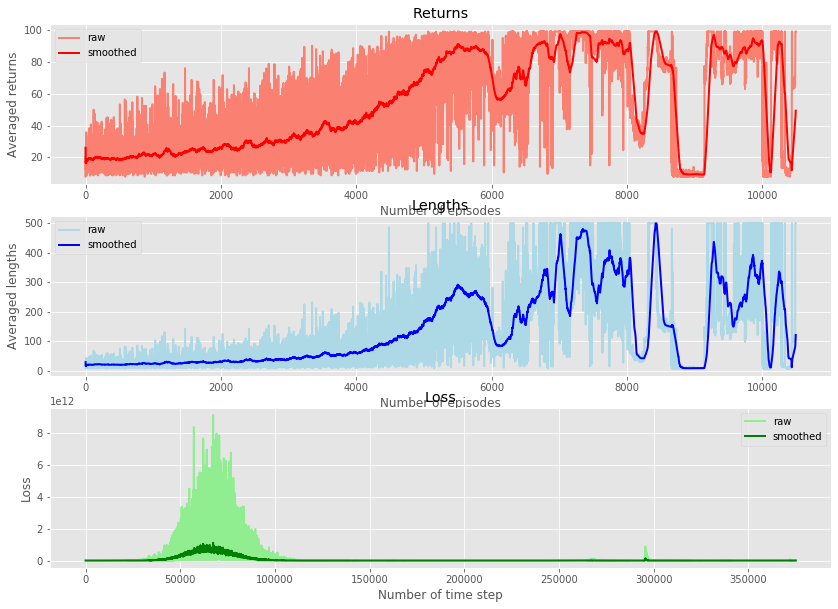

In [13]:
# YOUR PLOTS HERE
epochs = np.arange(len(returns))

# smooth data
smoothed_returns = rolling_average(returns, window_size = 100)
smoothed_lengths = rolling_average(lengths, window_size = 100)
smoothed_losses = rolling_average(losses, window_size = 100)

# plot the returns
fig = plt.figure(figsize=(14, 10))
ax1 = fig.add_subplot(311)
line_1, = ax1.plot(epochs, returns, 'salmon', linewidth=2.0)
line_2, = ax1.plot(epochs, smoothed_returns, 'r', linewidth=2.0)
plt.xlabel('Number of episodes')
plt.ylabel('Averaged returns')
plt.title('Returns')
plt.legend((line_1, line_2), ('raw', 'smoothed'))

ax2 = fig.add_subplot(312)
line_1, = ax2.plot(epochs, lengths, 'lightblue', linewidth=2.0)
line_2, = ax2.plot(epochs, smoothed_lengths, 'b', linewidth=2.0)
plt.xlabel('Number of episodes')
plt.ylabel('Averaged lengths')
plt.title('Lengths')
plt.legend((line_1, line_2), ('raw', 'smoothed'))
ax3 = fig.add_subplot(313)
epochs = np.arange(len(losses))
line_1, = ax3.plot(epochs, losses, 'lightgreen', linewidth=2.0)
line_2, = ax3.plot(epochs, smoothed_losses, 'g', linewidth=2.0)
plt.xlabel('Number of time step')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend((line_1, line_2), ('raw', 'smoothed'))
plt.show()

SpaceInvaders

In [17]:
env = envs['Alien']
gamma = 0.99

# we train for many time-steps;  as usual, you can decrease this during development / debugging.
# but make sure to restore it to 1_500_000 before submitting.
# num_steps = 1_500_000
num_steps = 1_500_00
num_saves = 5  # save models at 0%, 25%, 50%, 75% and 100% of training

# replay_size = 200_000
# replay_prepopulate_steps = 50_000
replay_size = 200_00
replay_prepopulate_steps = 500_00

batch_size = 64
# exploration = ExponentialSchedule(1.0, 0.05, 1_000_000)
exploration = ExponentialSchedule(1.0, 0.05, 1_000_00)

# this should take about 90-120 minutes on a generic 4-core laptop
dqn_models, returns, lengths, losses = train_dqn(
    env,
    num_steps,
    num_saves=num_saves,
    replay_size=replay_size,
    replay_prepopulate_steps=replay_prepopulate_steps,
    batch_size=batch_size,
    exploration=exploration,
    gamma=gamma,
)

assert len(dqn_models) == num_saves
assert all(isinstance(value, DQN) for value in dqn_models.values())

# saving computed models to disk, so that we can load and visualize them later.
checkpoint = {key: dqn.custom_dump() for key, dqn in dqn_models.items()}
torch.save(checkpoint, f'checkpoint_{env.spec.id}.pt')

KeyboardInterrupt: 

###### (3 pts) Plot the returns, lengths and losses obtained while running DQN on the cartpole environment.

Again, plot the raw data and the smoothened data **inside the same plot**, i.e. you should have 3 plots total.

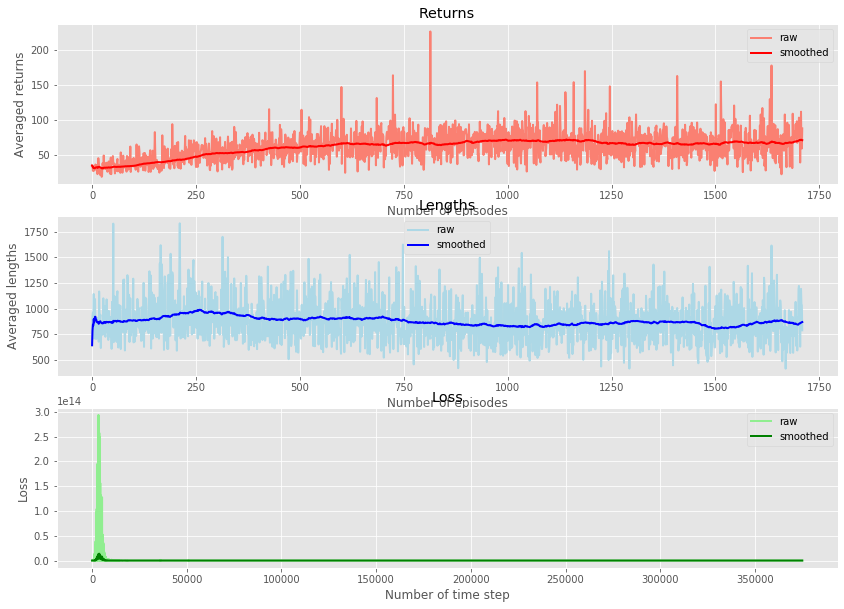

In [15]:
# YOUR PLOTS HERE
epochs = np.arange(len(returns))

# smooth data
smoothed_returns = rolling_average(returns, window_size = 100)
smoothed_lengths = rolling_average(lengths, window_size = 100)
smoothed_losses = rolling_average(losses, window_size = 100)

# plot the returns
fig = plt.figure(figsize=(14, 10))
ax1 = fig.add_subplot(311)
line_1, = ax1.plot(epochs, returns, 'salmon', linewidth=2.0)
line_2, = ax1.plot(epochs, smoothed_returns, 'r', linewidth=2.0)
plt.xlabel('Number of episodes')
plt.ylabel('Averaged returns')
plt.title('Returns')
plt.legend((line_1, line_2), ('raw', 'smoothed'))

ax2 = fig.add_subplot(312)
line_1, = ax2.plot(epochs, lengths, 'lightblue', linewidth=2.0)
line_2, = ax2.plot(epochs, smoothed_lengths, 'b', linewidth=2.0)
plt.xlabel('Number of episodes')
plt.ylabel('Averaged lengths')
plt.title('Lengths')
plt.legend((line_1, line_2), ('raw', 'smoothed'))
ax3 = fig.add_subplot(313)
epochs = np.arange(len(losses))
line_1, = ax3.plot(epochs, losses, 'lightgreen', linewidth=2.0)
line_2, = ax3.plot(epochs, smoothed_losses, 'g', linewidth=2.0)
plt.xlabel('Number of time step')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend((line_1, line_2), ('raw', 'smoothed'))
plt.show()

### Visualization of the trained policies!

Run the cell below and push the buttons to view the progress of the policy trained using DQN.

In [77]:
buttons_all = []
for key_env, env in envs.items():
    try:
        checkpoint = torch.load(f'checkpoint_{env.spec.id}.pt')
    except FileNotFoundError:
        pass
    else:
        buttons = []
        for key, value in checkpoint.items():
            dqn = DQN.custom_load(value)
            
            def make_callback(env, dqn):
                def button_callback(button):
                    for b in buttons_all:
                        b.disabled = True
                        
                    render(env, lambda state: dqn(torch.tensor(state, dtype=torch.float)).argmax().item())
                    
                    for b in buttons_all:
                        b.disabled = False
                        
                return button_callback
                
            button = widgets.Button(description=f'{key.replace("_", ".")}%')
            button.on_click(make_callback(env, dqn))
            buttons.append(button)
        
        print(f'{key_env}:')
        display(widgets.HBox(buttons))
        buttons_all.extend(buttons)

TypeError: 'int' object is not subscriptable

### Exercise 7 (20 pts): Analysis

For each environment, describe the progress of the training in terms of the behavior of the agent at each of the 5 phases of training (i.e. 0%, 25%, 50%, 75%, 100%).  Make sure you view each phase a few times so that you can see all sorts of variations.

Say something for each phase (i.e. this exercise is worth 1 point for every phase of every environment).  Start by describing the behavior at phase 0%, then, for each next phase, describe how it differs from the previous one, how it improves and/or how it becomes worse.  At the final phase (100%), also describe the observed behavior in absolute terms, and whether it has achieved optimality.

##### CartPole (5pts)

* 0%) YOUR ANSWER HERE. It this phase, the agent doesn't start to learn anything. Therefore, normally, the episode just terminates immediately because of the pole violates the 15 degree condtion.
* 25%) YOUR ANSWER HERE. At this stage, the agent learns pretty well and almost keeps the car in the center and the pole in the middle.
* 50%) YOUR ANSWER HERE. At this stage, the agent's performance becomes worse. I suspect this is because of the something bad happens to the reply memory and leads to a bad update of the weights. This is also showed in the loss figure, where it has a bump in the middle. The car keeps dives to the left to balance the pole back to the center.
* 75%) YOUR ANSWER HERE. In this phase, the performance becomes better compared to 50%. The cart heads to the left and can keeps the pole back to the center after some movement. However, it still goes too far from the trail center.
* 100%) YOUR ANSWER HERE. In this phase, the performance is better. However, the car perform well at the begining,then suddenly it has a big acceleration speed to the right. This behaviour leads to a big change of the angle of the pole to the left. However, the general ability for the car to keep the angle limitation is good. Sometimes, it can perform really well.